In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import numpy as np
import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectrum as spectrum
import darkhistory.spec.spectra as spectra
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tfl
import matplotlib
import matplotlib.pyplot as plt
import pickle

np.set_printoptions(threshold=np.nan)
matplotlib.rcParams['figure.figsize'] = [10,10]


from scipy import integrate
from astropy.io import fits
from tqdm import tqdm_notebook as tqdm

In [3]:
transfer_func_table = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/transfer_func_table.raw","rb"))

In [4]:
eng = transfer_func_table.in_eng
tf_rs_arr = transfer_func_table.rs

In [5]:
#Initialize
eng_ind = 99
mwimp = eng[eng_ind]
print(mwimp)
coarsen_factor = 10

rs_list = np.exp(np.arange(np.log(tf_rs_arr[0]), 
                           np.log(tf_rs_arr[-1]), 
                           -transfer_func_table.dlnz*coarsen_factor)
                )

# Initial injection is 2 photons, to match up with what we have in file.
photon_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                        np.array([mwimp]), 
                                        eng)
                                       
photon_spec_init.rs = rs_list[0]

207661.376877


In [6]:
if coarsen_factor > 1:
    transfer_func_table.coarsen(coarsen_factor, delete_tfs=False)

In [7]:
transfer_func_table.at_val('rs',rs_list)

In [8]:
photon_spectra = spectools.evolve(photon_spec_init, transfer_func_table, save_steps=True)
fin_phot_spec = spectools.evolve(photon_spec_init, transfer_func_table, end_rs=13)

In [9]:
photon_spectra.get_rs()

array([ 31.        ,  30.38615887,  29.78447261,  29.19470054,
        28.61660674,  28.04995996,  27.49453354,  26.9501053 ,
        26.41645746,  25.89337655,  25.38065335,  24.87808274,
        24.38546369,  23.90259916,  23.42929599,  22.96536484,
        22.51062015,  22.06488001,  21.62796611,  21.19970369,
        20.77992143,  20.36845141,  19.96512905,  19.56979301,
        19.18228515,  18.80245045,  18.43013699,  18.06519582,
        17.70748098,  17.35684936,  17.01316072,  16.67627757,
        16.34606515,  16.02239137,  15.70512676,  15.39414442,
        15.08931993,  14.79053138,  14.49765924,  14.21058635,
        13.92919789,  13.65338129,  13.38302623,  13.11802455,
        12.85827026,  12.60365945,  12.35409027,  12.1094629 ,
        11.86967947,  11.63464406,  11.40426268,  11.17844315,
        10.95709514,  10.74013012,  10.52746129,  10.31900359,
        10.11467363,   9.91438968,   9.71807161,   9.5256409 ,
         9.33702057,   9.15213517,   8.97091076,   8.79

In [10]:
file_name = {99: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_5.328E+00_xe_1.000E-04.fits",
            199: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_7.183E+00_xe_1.000E-04.fits",
            298: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.020E+00_xe_1.000E-04.fits",
            299: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits", 
            399: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.089E+01_xe_1.000E-04.fits",
            499: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.275E+01_xe_1.000E-04.fits",
            2993: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_18_logE_9.038E+00_xe_1.000E-04.fits"}

file = fits.open(file_name[eng_ind])

file_eng = file[1].data['energy'][0,:]
file_rs = file[1].data['redshift'][0,:]
file_photonspectrum = file[1].data['photonspectrum'][0,:,:]

In [11]:
file_spectra = spectra.Spectra([spectrum.Spectrum(file_eng, photspec, rs) 
                   for photspec,rs in zip(file_photonspectrum, file_rs)])

In [12]:
print(photon_spectra.get_rs())
file_spectra.get_rs()[0]
file_spectra.get_rs()[-10:-1]

[ 31.          30.38615887  29.78447261  29.19470054  28.61660674
  28.04995996  27.49453354  26.9501053   26.41645746  25.89337655
  25.38065335  24.87808274  24.38546369  23.90259916  23.42929599
  22.96536484  22.51062015  22.06488001  21.62796611  21.19970369
  20.77992143  20.36845141  19.96512905  19.56979301  19.18228515
  18.80245045  18.43013699  18.06519582  17.70748098  17.35684936
  17.01316072  16.67627757  16.34606515  16.02239137  15.70512676
  15.39414442  15.08931993  14.79053138  14.49765924  14.21058635
  13.92919789  13.65338129  13.38302623  13.11802455  12.85827026
  12.60365945  12.35409027  12.1094629   11.86967947  11.63464406
  11.40426268  11.17844315  10.95709514  10.74013012  10.52746129
  10.31900359  10.11467363   9.91438968   9.71807161   9.5256409
   9.33702057   9.15213517   8.97091076   8.79327482   8.61915631
   8.44848558   8.28119436   8.11721573   7.95648409   7.79893514
   7.64450588   7.49313452   7.34476052   7.19932452   7.05676834
   6.917034

array([ 4.03492294,  4.03089004,  4.02686116,  4.02283631,  4.01881549,
        4.01479868,  4.01078589,  4.00677711,  4.00277233])

/Users/hongwan/GitHub/DarkHistory/darkhistory/spec/spectrum.py:618: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


[0.0001, 10000000000000.0, 1e-22, 1000.0]

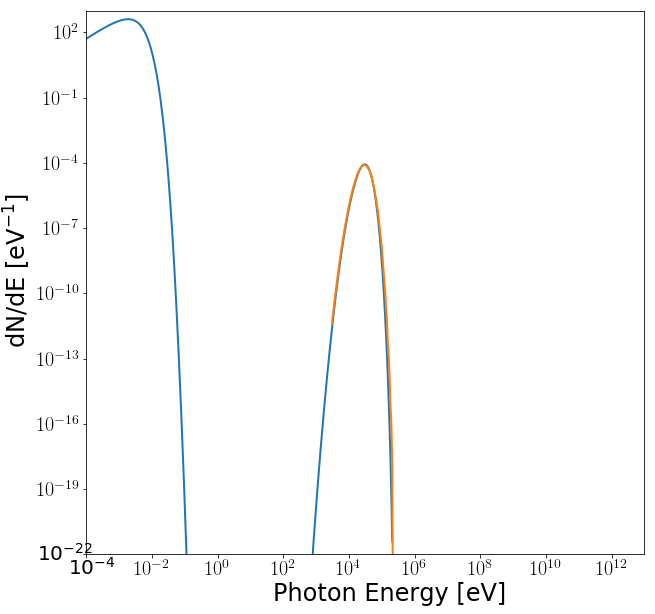

In [13]:
rs_to_plot = 5

photon_spectra.rebin(file_spectra.get_eng())

ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

file_spectra.plot(ax, ind=rs_to_plot, indtype='rs', linewidth=2)
photon_spectra.plot(ax, ind=rs_to_plot, indtype='rs', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE [eV$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e13, 1e-22, 1e3])


/Users/hongwan/GitHub/DarkHistory/darkhistory/spec/spectrum.py:339: RuntimeWarning: divide by zero encountered in true_divide
  invSpec = Spectrum(self.eng, 1/self.dNdE, self.rs)
/Users/hongwan/GitHub/DarkHistory/darkhistory/spec/spectrum.py:254: RuntimeWarning: invalid value encountered in multiply
  return Spectrum(self.eng, self.dNdE*other.dNdE, self.rs)


[1000.0, 10000000000.0, 0.001, 100000.0]

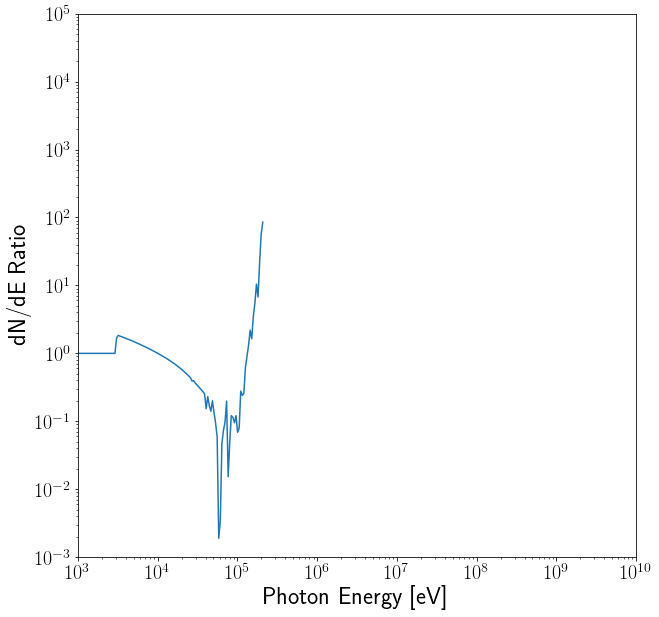

In [18]:
file_spectra = file_spectra.at_rs(photon_spectra.get_rs(), bounds_err=False)

ratio = (photon_spectra-file_spectra)/file_spectra

ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

ratio.plot(ax, ind=50, abs_plot=True, indtype='ind')
ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE Ratio',fontsize=24)
plt.axis([1e3, 1e10, 1e-3, 1e5])

In [15]:
utils.compare_arr([file_spectra[1].eng, file_spectra[1].dNdE, photon_spectra[1].dNdE])
print(file_spectra[1].rs)

[[  1.02296232e-04   1.83715332e+03   0.00000000e+00]
 [  1.07048086e-04   1.92177808e+03   0.00000000e+00]
 [  1.12020673e-04   2.01026660e+03   0.00000000e+00]
 [  1.17224246e-04   2.10278979e+03   0.00000000e+00]
 [  1.22669536e-04   2.19953247e+03   0.00000000e+00]
 [  1.28367769e-04   2.30067847e+03   0.00000000e+00]
 [  1.34330696e-04   2.40642358e+03   0.00000000e+00]
 [  1.40570612e-04   2.51697778e+03   0.00000000e+00]
 [  1.47100384e-04   2.63255127e+03   0.00000000e+00]
 [  1.53933476e-04   2.75336401e+03   0.00000000e+00]
 [  1.61083979e-04   2.87964990e+03   0.00000000e+00]
 [  1.68566636e-04   3.01165015e+03   0.00000000e+00]
 [  1.76396877e-04   3.14961230e+03   0.00000000e+00]
 [  1.84590847e-04   3.29380469e+03   0.00000000e+00]
 [  1.93165443e-04   3.44449194e+03   0.00000000e+00]
 [  2.02138345e-04   3.60195972e+03   0.00000000e+00]
 [  2.11528055e-04   3.76650269e+03   0.00000000e+00]
 [  2.21353936e-04   3.93842871e+03   0.00000000e+00]
 [  2.31636247e-04   4.11805